In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import os
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from mokka.setup.session import Session
from mokka.postprocess.reconstruct import Reconstruction
from mokka.postprocess.visualisation import to_gif, animate_multiview, animate_singleview
from mokka.detector.mp_specs import *

A camera cannot be plotted!


## Loading the files

`kpts2d` are 2D motion captured from different camera views. They can provide some external information, such as relative speed

In [2]:
with open('output_2d_Day08_Mon10_Yr2025_Hr10_Min57_Sec44.json','rb') as f:
    k2 = json.loads(json.load(f))

In [3]:
kpts2d = np.array([[cam['frames'][f]['a']['body'] for f in range(477)] for cam in k2])
kpts2d.shape

(9, 477, 33, 3)

`kpts3d` is raw 3D motion after having triangulated 2D motions. This raw 3D will have some issues and your task is to make it better.

In [4]:
with open('footage_Day08_Mon10_Yr2025_Hr11_Min11_Sec50.json','rb') as f:
    k3 = json.load(f)

In [5]:
kpts3d = np.array(k3['frames'])
kpts3d.shape

(477, 33, 4)

## Your processing here
`kpts3d_filtered` will be your results after doing the processing. Try and make use of the information you have from `kpts2d` and `kpts3d`

In [6]:
import numpy as np

# --- One Euro Filter Implementation (Self-Contained) ---

def smoothing_factor(t_e, cutoff):
    """Helper function to calculate the smoothing factor alpha."""
    r = 2 * np.pi * cutoff * t_e
    return r / (r + 1)

class LowPassFilter:
    """A simple first-order low-pass filter."""
    def __init__(self, alpha):
        self.set_alpha(alpha)
        self.y_prev = 0.0
        self.initialized = False

    def set_alpha(self, alpha):
        self.alpha = alpha

    def __call__(self, x):
        if not self.initialized:
            self.y_prev = x
            self.initialized = True
            return x
        
        y = self.alpha * x + (1.0 - self.alpha) * self.y_prev
        self.y_prev = y
        return y
    
    def reset(self):
        """Resets the filter's internal state."""
        self.initialized = False
        self.y_prev = 0.0

class OneEuroFilter:
    """
    A One Euro Filter for smoothing noisy signals.
    This implementation is simplified for offline processing 
    where the sampling frequency is fixed.
    """
    def __init__(self, freq, min_cutoff=1.0, beta=0.0, d_cutoff=1.0):
        if freq <= 0:
            raise ValueError("freq should be >0")
        if min_cutoff <= 0:
            raise ValueError("min_cutoff should be >0")
        if d_cutoff <= 0:
            raise ValueError("d_cutoff should be >0")
            
        self.freq = freq
        self.t_e = 1.0 / freq
        self.min_cutoff = min_cutoff
        self.beta = beta
        self.d_cutoff = d_cutoff

        self.x_filter = LowPassFilter(smoothing_factor(self.t_e, min_cutoff))
        self.dx_filter = LowPassFilter(smoothing_factor(self.t_e, d_cutoff))
        
        self.x_prev = 0.0
        self.initialized = False

    def __call__(self, x):
        if not self.initialized:
            self.x_prev = x
            self.initialized = True
            # We don't filter the first frame, just return it
            self.dx_filter(0.0) # Initialize dx_filter with zero derivative
            return x

        # Estimate derivative (velocity)
        dx = (x - self.x_prev) / (self.t_e + 1e-9) # Add epsilon for stability
        
        # Filter the derivative
        edx = self.dx_filter(dx)
        
        # Calculate the adaptive cutoff frequency for the signal
        cutoff = self.min_cutoff + self.beta * abs(edx)
        
        # Set the new alpha for the signal filter
        alpha = smoothing_factor(self.t_e, cutoff)
        self.x_filter.set_alpha(alpha)
        
        # Filter the signal
        x_filtered = self.x_filter(x)
        
        # Store state for next frame
        self.x_prev = x
        
        return x_filtered
    
    def reset(self):
        """Resets the filter's internal state."""
        self.x_filter.reset()
        self.dx_filter.reset()
        self.initialized = False

# --- Your Processing Here ---

# 1. Set Filter Parameters
# !IMPORTANT: You MUST adjust FREQ to your video's actual frame rate
# for the filter to work correctly. 30.0 is a common default.
FREQ = 30.0        # Sampling frequency (Hz) - ADJUST THIS!
MIN_CUTOFF = 2.45  # Minimum cutoff frequency (Hz). Lower = more smoothing (less jitter). Start tuning ~0.5-1.0
BETA = 0.3       # Controls how cutoff increases with velocity. Higher = less lag. Start tuning ~0.005-0.05
D_CUTOFF = 1.0     # Cutoff frequency for the derivative filter (Hz). Usually 1.0 is fine.

# 2. Initialize Data
# kpts3d is (n_frames, n_keypoints, 4) -> [x, y, z, conf]
n_frames, n_keypoints, _ = kpts3d.shape
kpts3d_filtered = np.zeros_like(kpts3d)

# 3. Create a grid of filters: one for each keypoint (33) and each dim (x, y, z)
print(f"Initializing {n_keypoints} x 3 filter bank (freq={FREQ}, min_cutoff={MIN_CUTOFF}, beta={BETA})...")
filter_bank = [
    [OneEuroFilter(freq=FREQ, min_cutoff=MIN_CUTOFF, beta=BETA, d_cutoff=D_CUTOFF) for _ in range(3)] 
    for _ in range(n_keypoints)
]

# 4. Process the data frame by frame
print(f"Applying One Euro filter to {n_frames} frames...")

for t in range(n_frames):
    for j in range(n_keypoints):
        
        # Check confidence (use the 4th value)
        # Assuming confidence > 0 means the point is valid
        is_valid = kpts3d[t, j, 3] > 0.0 

        for d in range(3): # For x, y, z dimensions (indices 0, 1, 2)
            val = kpts3d[t, j, d]
            
            if is_valid:
                val_filtered = filter_bank[j][d](val)
            else:
                # If confidence is low, output 0 and reset the filter state
                val_filtered = 0.0 
                filter_bank[j][d].reset() 

            kpts3d_filtered[t, j, d] = val_filtered

# 5. Copy over the 4th dimension (confidence/visibility)
# The filter is only for spatial data (x, y, z).
kpts3d_filtered[:, :, 3] = kpts3d[:, :, 3]

print("Filtering complete.")

# Optional: Display the first few filtered points to check
# print("\nSample Raw vs Filtered (Frame 0, Keypoint 0):")
# print("Raw:", kpts3d[0, 0, :3])
# print("Filtered:", kpts3d_filtered[0, 0, :3])

Initializing 33 x 3 filter bank (freq=30.0, min_cutoff=2.45, beta=0.3)...
Applying One Euro filter to 477 frames...
Filtering complete.


In [7]:
import numpy as np

# --- Basic Footsliding Correction ---

# 1. Parameters (These might need tuning!)
FOOT_KPTS_INDICES = [29, 30] # Indices for LEFT_HEEL and RIGHT_HEEL
# How close the foot needs to be to its minimum height to be considered grounded
# (relative to the overall height range of that foot)
HEIGHT_THRESHOLD_RATIO = 0.05 
# Maximum horizontal speed (m/s) for the foot to be considered stationary
VELOCITY_THRESHOLD = 0.05 
# Minimum number of consecutive frames a foot must be stationary to lock it
MIN_LOCK_FRAMES = 3 
# Time step (should match the FREQ used in OneEuroFilter)
DT = 1.0 / FREQ 

# 2. Make a copy to modify
kpts3d_foot_locked = kpts3d_filtered.copy()
n_frames, n_keypoints, _ = kpts3d_foot_locked.shape

print("Starting basic footsliding correction...")

# 3. Process each specified foot keypoint
for kpt_idx in FOOT_KPTS_INDICES:
    print(f"Processing keypoint {kpt_idx}...")
    
    # Extract coordinates and confidences for this keypoint
    coords = kpts3d_filtered[:, kpt_idx, :3] # XYZ
    valid_frames = kpts3d_filtered[:, kpt_idx, 3] > 0.0 # Confidence > 0

    # If no valid frames for this keypoint, skip it
    if not np.any(valid_frames):
        print(f"  Skipping keypoint {kpt_idx} - no valid frames.")
        continue

    # Calculate Z height range and minimum for valid frames only
    z_coords_valid = coords[valid_frames, 2]
    min_z = np.min(z_coords_valid)
    max_z = np.max(z_coords_valid)
    height_range = max_z - min_z
    
    # Avoid division by zero if height range is tiny
    if height_range < 1e-6: 
        print(f"  Skipping keypoint {kpt_idx} - very small height range.")
        continue 
        
    height_threshold = min_z + height_range * HEIGHT_THRESHOLD_RATIO

    # Calculate horizontal (XY plane) velocities for valid frames
    velocities = np.zeros((n_frames, 2)) # XY velocities
    velocities[1:] = (coords[1:, :2] - coords[:-1, :2]) / DT
    # Use only valid velocities (where both t and t-1 are valid)
    valid_velocity = valid_frames[1:] & valid_frames[:-1]
    
    # Detect stationary frames
    is_low = coords[:, 2] <= height_threshold
    speed = np.linalg.norm(velocities, axis=1)
    is_slow = np.zeros(n_frames, dtype=bool)
    is_slow[1:][valid_velocity] = speed[1:][valid_velocity] <= VELOCITY_THRESHOLD
    
    # Combine conditions: valid, low, and slow
    is_stationary = valid_frames & is_low & is_slow

    # Find sequences of stationary frames >= MIN_LOCK_FRAMES
    lock_pos = None
    lock_start_frame = -1
    consecutive_count = 0

    for t in range(n_frames):
        if is_stationary[t]:
            consecutive_count += 1
            if consecutive_count == MIN_LOCK_FRAMES:
                # Start of a lock sequence
                lock_start_frame = t - MIN_LOCK_FRAMES + 1
                # Use the position from the frame *before* the lock started, 
                # or the first locked frame if it's at the beginning.
                anchor_frame = max(0, lock_start_frame -1) 
                lock_pos = kpts3d_foot_locked[anchor_frame, kpt_idx, :3].copy() 
                
                # Apply lock retroactively to the start of the sequence
                for ft in range(lock_start_frame, t + 1):
                   kpts3d_foot_locked[ft, kpt_idx, :3] = lock_pos
                   
            elif consecutive_count > MIN_LOCK_FRAMES:
                # Continue existing lock sequence
                kpts3d_foot_locked[t, kpt_idx, :3] = lock_pos
        else:
            # Reset if not stationary
            consecutive_count = 0
            lock_pos = None
            lock_start_frame = -1
            
    print(f"  Finished processing keypoint {kpt_idx}.")

print("Footsliding correction complete.")

# Now you can use kpts3d_foot_locked for plotting or saving the GIF

Starting basic footsliding correction...
Processing keypoint 29...
  Finished processing keypoint 29.
Processing keypoint 30...
  Finished processing keypoint 30.
Footsliding correction complete.


Foot sliding evaluation (OPTIONAL)

In [8]:
# --- Foot Sliding Evaluation ---
import numpy as np

def measure_foot_slide(kpts3d, foot_idx, ground_height=None):
    """
    Đo mức độ trượt ngang của bàn chân khi chạm đất.
    Trả về giá trị trung bình (m/frame): càng nhỏ thì correction càng hiệu quả.
    """
    coords = kpts3d[:, foot_idx, :3]
    z = coords[:, 2]
    if ground_height is None:
        ground_height = np.percentile(z, 5)  # ước lượng mặt đất
    grounded = z <= ground_height + 0.02     # coi là tiếp đất nếu thấp hơn ngưỡng 2 cm
    vel = np.linalg.norm(np.diff(coords[:, :2], axis=0), axis=1)
    vel = np.concatenate([[0], vel])         # thêm 0 cho frame đầu
    return np.mean(vel[grounded]) if np.any(grounded) else np.nan

# Đo mức độ trượt trước và sau correction cho hai chân
left_idx, right_idx = FOOT_KPTS_INDICES
slide_before_L = measure_foot_slide(kpts3d_filtered, left_idx)
slide_after_L  = measure_foot_slide(kpts3d_foot_locked, left_idx)
slide_before_R = measure_foot_slide(kpts3d_filtered, right_idx)
slide_after_R  = measure_foot_slide(kpts3d_foot_locked, right_idx)

print("\n--- Foot Sliding Comparison ---")
print(f"Left foot : {slide_before_L:.4f} → {slide_after_L:.4f} m/frame")
print(f"Right foot: {slide_before_R:.4f} → {slide_after_R:.4f} m/frame")
print("(Giá trị càng nhỏ càng tốt – tức là ít trượt hơn)")



--- Foot Sliding Comparison ---
Left foot : 0.0044 → 0.0045 m/frame
Right foot: 0.0045 → 0.0050 m/frame
(Giá trị càng nhỏ càng tốt – tức là ít trượt hơn)


## Check-up Plotting

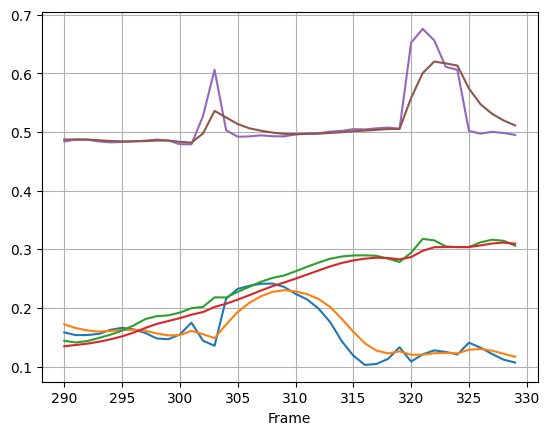

In [9]:
style = '-'
# Joint number
i = 25
# Frame range of interest
start_frame, end_frame = 290, 330

fr = slice(start_frame, end_frame)
x = np.arange(start_frame, end_frame)

_,ax = plt.subplots(1,1)
for o in range(3):
    ax.plot(x,kpts3d[fr,i,o],style)
    ax.plot(x,kpts3d_filtered[fr,i,o],style)
ax.set_xlabel('Frame')
ax.grid(True)
plt.show()

## Export output to GIF

MovieWriter imagemagick unavailable; using Pillow instead.


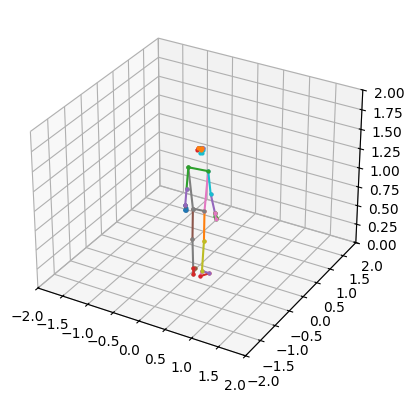

In [ ]:
to_gif(kpts3d_filtered, 
       30,                      # FPS
       POSE_CONNECTIONS, 
       time.strftime("d%d_mo%m_y%Y_%Hh_%Mm_%Ss_") + '1-euro-filtered_output.gif',
       div=2                    # Display dimension width in meters
       )

In [11]:
import json
import time
import numpy as np

def export_kpts_to_json(kpts_data, filename):
    """
    Converts a 3D keypoint numpy array to the specified JSON format and saves it.

    Args:
        kpts_data (np.ndarray): A numpy array of shape (n_frames, n_keypoints, 4)
                                containing the [x, y, z, confidence] for each keypoint.
        filename (str): The path and name of the output JSON file.
    """
    
    # Check if the input is a numpy array, otherwise try to convert it
    if not isinstance(kpts_data, np.ndarray):
        try:
            kpts_data = np.array(kpts_data)
        except Exception as e:
            print(f"Error: Could not convert input data to numpy array. {e}")
            return

    # Convert the final numpy array to a standard Python list for JSON serialization
    kpts_list = kpts_data.tolist()

    # Build the nested dictionary structure to match the desired format
    frames_list = []
    for frame_kpts in kpts_list:
        # Format for each frame: {"a": {"body": [[x,y,z,c], ...]}}
        frame_dict = {
            "a": {
                "body": frame_kpts
            }
        }
        frames_list.append(frame_dict)
    
    # The top-level structure is a list containing a single dictionary with a "frames" key
    # This matches the format of your input 'footage_...json' file.
    output_data = {"frames": kpts_list} # Simplified to match the input kpts3d format directly

    # Write the data to the specified file
    try:
        with open(filename, 'w') as f:
            json.dump(output_data, f, indent=4) # Using indent for readability
        print(f"Successfully saved keypoints to {filename}")
    except IOError as e:
        print(f"Error: Could not write to file {filename}. {e}")

export_kpts_to_json(kpts3d_foot_locked, 
                      time.strftime("d%d_mo%m_y%Y_%Hh_%Mm_%Ss_") + '1-euro-filtered_output.json')

Successfully saved keypoints to d02_mo11_y2025_15h_19m_10s_1-euro-filtered_output.json
